# Euclid Forward model

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.PKDGRAV_and_postprocessing_utilities import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass

In [1]:
0

0

# Setup forward model

In [3]:
# Setup     ********************************
path_simulation = '/pscratch/sd/m/mgatti/highres_SBI/Flagship_covariance_big/4_big/'

#
baryonification = False
nside_baryonification = 1024
nside_maps = 1024
max_redshift_halo_catalog = 1.5
halo_catalog_log10mass_cut = 13

# source clustering correction ----------------------------------
bias_sc = np.ones(6+1)
corr_noise_variance_sc = np.ones(6+1)
coeff_noise_kurtosis_sc = np.zeros(6+1)

# if you need to do SC calibration use these
corr_variance_array = np.ones(6+1)
coeff_kurtosis_array = np.zeros(6+1)
A_corr_array  = np.ones(6+1)

# I have alraeady done SC calibration
corr_variance_array = [1.0415033318429654,
 1.057557190085899,
 1.0449841883097524,
 1.0433576278968444,
 1.038150109781628,
 1.0426072451617292,
 1.0361224593656755]

coeff_kurtosis_array = [-0.0063994556522697236,
 -0.05310748260360052,
 -0.01818416274846952,
 0.07786601668679594,
 -0.04270710007778398,
 0.018915872822180137,
 -0.028718300332205463]

A_corr_array = [0.999924642521132,
 0.9965642493403398,
 0.9993021627937851,
 1.002193896093479,
 0.9982323693546309,
 1.000860257399982,
 0.9977866348690164]


# get basic info --------------------
sims_parameters, cosmo_pyccl, camb_pars = read_sims_params(path_simulation)

shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)


# Load data

In [4]:
# Load / save Euclid data
# load catalog ~
import numpy as np
import pandas as pd

df = pd.read_parquet("/pscratch/sd/m/mgatti/euclid/catalog4.parquet")
df.keys()

'''SELECT
    `she_metacal_ra` AS `she_ra`,
    `she_metacal_dec` AS `she_dec`,
    `she_metacal_e1_corrected` AS `she_e1_corrected`,
    `she_metacal_e2_corrected` AS `she_e2_corrected`,
    `she_metacal_weight` AS `she_weight`,
    `tom_bin_id`
FROM
    euclid_rr2_r1_v1_1 
WHERE
    `tom_bin_id` > 0
    AND `she_metacal_weight` > 0
    AND `tile_index` NOT IN (102016422, 102016856, 102016857, 102016423, 102016424, 102017297, 102016858, 102019131, 102018674, 102018672, 102019596, 102019132, 102018673, 102019133, 102042322, 102041693, 102041070, 102041069, 102041695, 102041694)
    '''
#mask = (df['she_lensmc_e1_corrected']==df['she_lensmc_e1_corrected']) &(df['vis_det'] == 1) & (df['spurious_flag'] == 0)&  (df["phz_classification"] == 2) & (df["tom_bin_id"]>-1) & (df["she_metacal_weight"] > 0) #& & ((df['det_quality_flag'] & ~(1 | 2 | 512)) == 0) &
                    # (df["flux_vis_2fwhm_aper"] / df["fluxerr_vis_2fwhm_aper"] > 5) & # VIS-SNR cut already included in the others
                   # (~df["tile_index"].isin(bad_tile_ids))  # not affecting 30sq.deg crop
#print (len(mask[mask]))
#df = df[mask]


path_data_cats = '/pscratch/sd/m/mgatti/euclid/Euclid_cats.npy'
if not os.path.exists(path_data_cats):
#if True:
    cats_Euclid = dict()
    # Euclid ---------------------------------------------------------------------------------------
    for tomo in [0,1,2,3,4,5,6]:
        print (tomo)
        
        cats_Euclid[tomo] = dict()
    
        if tomo == 0:
            tomo_mask = df['tom_bin_id'] == df['tom_bin_id']
        else:
            tomo_mask = df['tom_bin_id'] == tomo
        
        #ra  =  np.array(df['she_metacal_ra'])[tomo_mask]
        #dec =  np.array(df['she_metacal_dec'])[tomo_mask]
        #e1  =  -np.array(df['she_metacal_e1_corrected'])[tomo_mask]
        #e2  =  np.array(df['she_metacal_e2_corrected'])[tomo_mask]
        #w   =  np.ones(len(np.array(df['she_metacal_weight'])[tomo_mask]))
    
    
        ra  =  np.array(df['she_ra'])[tomo_mask]
        dec =  np.array(df['she_dec'])[tomo_mask]
        e1  =  -np.array(df['she_e1_corrected'])[tomo_mask]
        e2  =  np.array(df['she_e2_corrected'])[tomo_mask]
        w   =  np.array(df['she_weight'])[tomo_mask]
    
        e1 -= np.sum(e1*w)/np.sum(w)
        e2 -= np.sum(e2*w)/np.sum(w)
        
        cats_Euclid[tomo]['ra'] = ra
        cats_Euclid[tomo]['dec'] = dec
        cats_Euclid[tomo]['e1'] = e1
        cats_Euclid[tomo]['e2'] = e2
        cats_Euclid[tomo]['w'] = w
    
    np.save(path_data_cats,cats_Euclid)
else:
    cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()


# Setup n(z)

In [5]:
# Setup n(z) ********************************
nz_file = fits.open('/pscratch/sd/m/mgatti/euclid/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z.fits')

nz = []
redshift = np.linspace(0,6,3001)
n_bins = 50
bin_factor = len(nz_file[1].data['N_Z'][0]) // n_bins 
n_trim = bin_factor * n_bins 
z_rebinned = redshift[:n_trim].reshape(n_bins, bin_factor).mean(axis=1)

############################################
nz_ = nz_file[1].data['N_Z'][0]+nz_file[1].data['N_Z'][1]+nz_file[1].data['N_Z'][2]+nz_file[1].data['N_Z'][3]+nz_file[1].data['N_Z'][4]+nz_file[1].data['N_Z'][5]
nz_rebinned = nz_[:n_trim].reshape(n_bins, bin_factor).sum(axis=1)
norm = np.trapz(nz_rebinned,z_rebinned)
nz.append(nz_rebinned/norm)

for ix in [1,2,3,4,5,6]:
    nz_ = nz_file[1].data['N_Z'][ix-1]
    nz_rebinned = nz_[:n_trim].reshape(n_bins, bin_factor).sum(axis=1)
    norm = np.trapz(nz_rebinned,z_rebinned)
    nz.append(nz_rebinned/norm)
nz = np.array(nz)
redshift = copy.deepcopy(z_rebinned)


shells = []
steps = []
zeff_array = []
for row in range(len((shells_info["Step"][::-1]))):
    step, zmin, zmax = shells_info["Step"][::-1][row], shells_info["z_near"][::-1][row], shells_info["z_far"][::-1][row]
    za = np.linspace(zmin, zmax, 100)
    wa = np.ones_like(za)
    zeff = (zmin + zmax)/2
    shells.append(glass.shells.RadialWindow(za, wa, zeff))
    steps.append(int(step))
    zeff_array.append(zeff)
ngal_glass  = np.array([glass.shells.partition(redshift, nz[i], shells) for i in range(nz.shape[0])])

In [90]:
'''
Compare with simulation - based n(z)
'''
import copy
nz_prov = []
for i in range(6):
    u = np.loadtxt('/pscratch/sd/m/mgatti/euclid/mean_sampled_nzs_6bins/density_False/equi_pop/nz_LCDM_nofz_FS2_area25deg2_DR1_opt_equi_pop_0{0}.cat'.format(i))
    redshift_1 =  copy.deepcopy(np.array(u)[:,0])
    nz_ =  copy.deepcopy(np.array(u)[:,1]  )
    nz_prov.append(nz_)
nz_prov = np.array(nz_prov)

nz = []
nz_ = np.sum(nz_prov,axis=0)
nz = np.vstack([nz_,nz_prov])

for i in range(len(nz)):
    nz[i] /= np.trapz(nz[i],redshift_1)

shells = []
steps = []
zeff_array = []
for row in range(len((shells_info["Step"][::-1]))):
    step, zmin, zmax = shells_info["Step"][::-1][row], shells_info["z_near"][::-1][row], shells_info["z_far"][::-1][row]
    za = np.linspace(zmin, zmax, 100)
    wa = np.ones_like(za)
    zeff = (zmin + zmax)/2
    zeff_array.append(zeff)
    shells.append(glass.shells.RadialWindow(za, wa, zeff))
    steps.append(int(step))
ngal_glass_1  = np.array([glass.shells.partition(redshift_1, nz[i], shells) for i in range(nz.shape[0])])

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)

for i in range(7):
    ax = axes[i]
    ax.plot(zeff_array, ngal_glass_1[i], label='sims')
    ax.plot(zeff_array, ngal_glass[i], label='data')
    ax.set_xlim([0, 6])
    ax.set_title(f'Bin {i}' if i > 0 else 'Non-tomo')
    if i == 0:
        ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
    if i == 6:
        ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

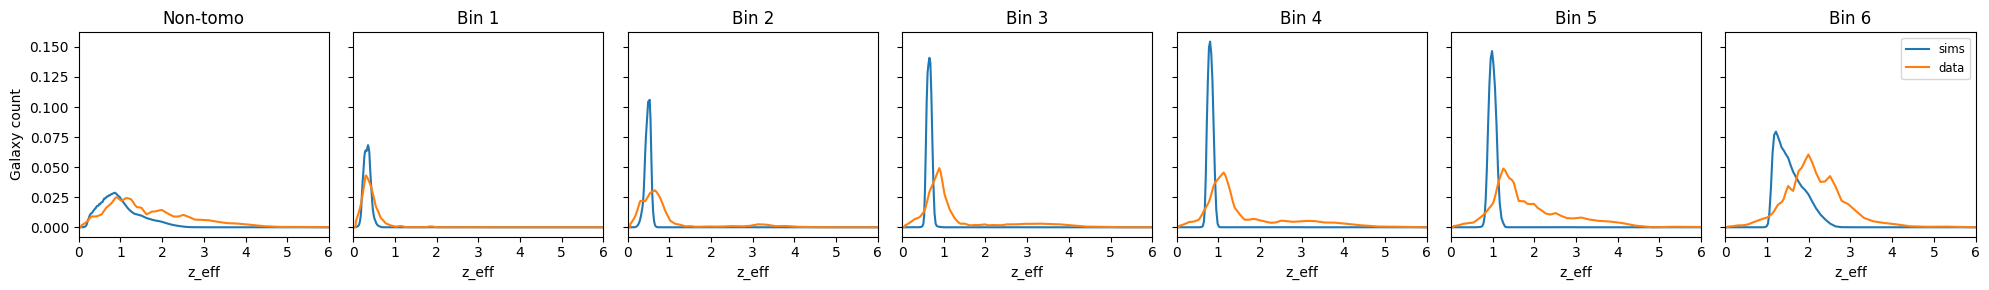

# Compute density/kappa (with or without baryonification)

In [6]:


# create halo catalog --------------------------------------------
#if not os.path.exists(path_simulation+ 'halo_catalog.parquet'):
#    save_halocatalog(shells_info, sims_parameters, max_redshift = max_redshift_halo_catalog, halo_snapshots_path = path_simulation, catalog_path = path_simulation + 'halo_catalog.parquet')


# baryonification -------------------------------------------------
if baryonification:

    label_baryonification = 'baryonified'
    # load into memory halocatalog
    df = pd.read_parquet(path_simulation + 'halo_catalog.parquet', engine='pyarrow')
    
    halos = dict()
    halos['M'] =  recover_halo_mass(df)  
    halos['z']  = recover_halo_redshift(df)  
    halos['ra'], halos['dec']  = recover_halo_radec(df)

    mask = np.log10(halos['M']) > halo_catalog_log10mass_cut
    halos['M'] = halos['M'][mask]
    halos['z'] = halos['z'][mask]
    halos['ra'] = halos['ra'][mask]
    halos['dec'] = halos['dec'][mask]
    
    bpar = np.load('../Data/Baryonification_default_parameters.npy',allow_pickle=True)

    #save "baryonified" density shells --------------------------------------
    if not os.path.exists(path_simulation + 'density_b_{0}.npy'.format(nside_maps)):

        density = []
        for i,step in enumerate(shells_info['Step'][::-1]):
            min_z = shells_info['z_near'][::-1][i]
            if i == 0:
                min_z += 1e6
            max_z = shells_info['z_far'][::-1][i]
        
         
            path = file + '/particles_{0}_4096.parquet'.format(int(step))
            counts = np.array(pd.read_parquet(path)).flatten()
            counts = counts.astype(np.float32)
            counts = hp.ud_grade(counts, nside_out=nside_baryonification, power=-2)
        
            density_baryonified = baryonify_shell(halos, sims_parameters, counts, bpar, min_z, max_z, nside_baryonification)    
            density.append(hp.ud_grade(density_baryonified,nside_out = nside_maps))
    
        density = np.array(density)
        np.save(path_simulation + 'density_b_{0}.npy'.format(nside_maps),density)
    else:
        density = np.load(path_simulation + 'density_b_{0}.npy'.format(nside_maps),allow_pickle=True)
        
        
else:

    label_baryonification = 'normal'
    #save "normal" density shells --------------------------------------
    if not os.path.exists(path_simulation+'/delta_{0}.npy'.format(nside_maps)):
        density = make_density_maps(shells_info,path_simulation,path_simulation+'/delta_{0}.npy'.format(nside_maps),nside_maps)
    else:
        density = np.load(path_simulation+'/delta_{0}.npy'.format(nside_maps),allow_pickle=True)


# compute kappa & shear *********
if not os.path.exists(path_simulation+'/gamma_glass_{0}_{1}.npy'.format(nside_maps,label_baryonification)):

    # Note: kappa field ill have the healpy pixel window function applied.
    # however, glass, when it computes gamma, automatically deconvolves it; it will be added later when making mocks and putting simulated galaxies into pixels -- 
    
    cosmo = Cosmology.from_camb(camb_pars)
    kappa_ = []
    gamma_ = []
    
    convergence = glass.lensing.MultiPlaneConvergence(cosmo)
    for ss in frogress.bar(range(len(density))):
       
        convergence.add_window(density[ss], shells[ss])
        # get convergence field
        kappa = copy.deepcopy(convergence.kappa)
        gamma = glass.lensing.from_convergence(kappa, lmax=nside_maps*3-1, shear=True)
        
        kappa_.append(kappa)
        gamma_.append(gamma)
 
    
    kappa_ = np.array(kappa_)
    gamma_ = np.array(gamma_)
    np.save(path_simulation+'/kappa_glass_{0}_{1}.npy'.format(nside_maps,label_baryonification),kappa_)
    np.save(path_simulation+'/gamma_glass_{0}_{1}.npy'.format(nside_maps,label_baryonification),gamma_)
else:
    kappa_ = np.load(path_simulation+'/kappa_glass_{0}_{1}.npy'.format(nside_maps,label_baryonification),allow_pickle=True)
    gamma_ = np.load(path_simulation+'/gamma_glass_{0}_{1}.npy'.format(nside_maps,label_baryonification),allow_pickle=True)



# make realistic maps with source clustering

In [7]:

kappa_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
g1_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
g2_tot  = np.zeros((nz.shape[0],12*nside_maps**2))
d_tot  = np.zeros((nz.shape[0], 12*nside_maps**2))


# load each lightcone output in turn and add it to the simulation
# note: I added a -sign to gamma to match data conventions later
for tomo in range(nz.shape[0]):
    for i in (range(len(kappa_))):       
        kappa_tot[tomo] += ngal_glass[tomo,i] * kappa_[i][0].real * (1 + bias_sc[tomo] * density[i])
        g1_tot[tomo] += ngal_glass[tomo,i] * (-gamma_[i][0].real) * (1 + bias_sc[tomo] * density[i])
        g2_tot[tomo] += ngal_glass[tomo,i] * (-gamma_[i][0].imag) * (1 + bias_sc[tomo] * density[i])
        d_tot[tomo]  += ngal_glass[tomo,i] * (1 + bias_sc[tomo] * density[i] )
   



maps_Gower = dict()
for tomo in range(nz.shape[0]):
    maps_Gower[tomo] = dict()

    pix = convert_to_pix_coord(cats_Euclid[tomo]['ra'],cats_Euclid[tomo]['dec'], nside=nside_maps)
    
    # source clustering term ~
    f = 1./np.sqrt(d_tot[tomo])
    f = f[pix]


    n_map = np.zeros(hp.nside2npix(nside_maps))
    n_map_sc = np.zeros(hp.nside2npix(nside_maps))

                    
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


    n_map_sc[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w']/f**2)
    n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w'])

    g1_ = g1_tot[tomo][pix]
    g2_ = g2_tot[tomo][pix]


    es1,es2 = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
    es1_ref,es2_ref = apply_random_rotation(cats_Euclid[tomo]['e1'], cats_Euclid[tomo]['e2'])
    es1a,es2a = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)


    x1_sc,x2_sc = addSourceEllipticity({'shear1':g1_,'shear2':g2_},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))


    e1r_map = np.zeros(hp.nside2npix (nside_maps))
    e2r_map = np.zeros(hp.nside2npix (nside_maps))
    e1r_map0 = np.zeros(hp.nside2npix(nside_maps))
    e2r_map0 = np.zeros(hp.nside2npix(nside_maps))
    e1r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
    e2r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
    g1_map = np.zeros(hp.nside2npix(nside_maps))
    g2_map = np.zeros(hp.nside2npix(nside_maps))

    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


    e1r_map[unique_pix] += np.bincount(idx_rep, weights=es1*cats_Euclid[tomo]['w'])
    e2r_map[unique_pix] += np.bincount(idx_rep, weights=es2*cats_Euclid[tomo]['w'])

    e1r_map0[unique_pix] += np.bincount(idx_rep, weights=es1a*cats_Euclid[tomo]['w'])
    e2r_map0[unique_pix] += np.bincount(idx_rep, weights=es2a*cats_Euclid[tomo]['w'])

    e1r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es1_ref*cats_Euclid[tomo]['w'])
    e2r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es2_ref*cats_Euclid[tomo]['w'])


    mask_sims = n_map_sc != 0.
    e1r_map[mask_sims]  = e1r_map[mask_sims]/(n_map_sc[mask_sims])
    e2r_map[mask_sims] =  e2r_map[mask_sims]/(n_map_sc[mask_sims])
    e1r_map0[mask_sims]  = e1r_map0[mask_sims]/(n_map_sc[mask_sims])
    e2r_map0[mask_sims] =  e2r_map0[mask_sims]/(n_map_sc[mask_sims])
    e1r_map0_ref[mask_sims]  = e1r_map0_ref[mask_sims]/(n_map[mask_sims])
    e2r_map0_ref[mask_sims] =  e2r_map0_ref[mask_sims]/(n_map[mask_sims])



    var_ =  e1r_map0_ref**2+e2r_map0_ref**2


    #'''
    e1r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e2r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e1r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    e2r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))

    
    #'''
    g1_map[unique_pix] += np.bincount(idx_rep, weights= g1_*cats_Euclid[tomo]['w'])
    g2_map[unique_pix] += np.bincount(idx_rep, weights= g2_*cats_Euclid[tomo]['w'])



    g1_map[mask_sims]  = g1_map[mask_sims]/(n_map_sc[mask_sims])
    g2_map[mask_sims] =  g2_map[mask_sims]/(n_map_sc[mask_sims])

    e1_ = ((g1_map+e1r_map0))#[mask_sims]
    e2_ = ((g2_map+e2r_map0))#[mask_sims]
    e1n_ = ( e1r_map)#[mask_sims]
    e2n_ = ( e2r_map)#[mask_sims]
   # idx_ = np.arange(len(mask_sims))[mask_sims]

    maps_Gower[tomo] =     {'g1_map':g1_map,'g2_map':g2_map,'e1':e1_,'e2':e2_,'e1n':e1n_,'e2n':e2n_,
                            'e1r_map0_ref':e1r_map0_ref,
                            'e2r_map0_ref':e2r_map0_ref,
                            'var_':var_}

# Determine SC coefficients

In [210]:
'''
I have already run this once to determine SC coefficients

source clustering increases variance! so x/y should be > 1

# This is the kind of correction we want.

#e1r_map   *= 1/(np.sqrt(A*corr_var)) * np.sqrt((1+coeff_kurtosis*var_))


# DES y3 in comparison
corr = [1.0608,1.0295,1.0188,1.0115]
coeff_kurtosis = [0.1,0.05,0.036,0.036]
A = 0.995
'''
from scipy.optimize import minimize

new_corr_variance_array = []
new_coeff_kurtosis_array = []
new_A_corr_array = [] 
for tomo in [0,1,2,3,4,5,6]:
    x = copy.deepcopy(maps_Gower[tomo]['e1n'][mask_sims]**2 + maps_Gower[tomo]['e2n'][mask_sims]**2)
    y = copy.deepcopy(maps_Gower[tomo]['e1r_map0_ref'][mask_sims]**2 + maps_Gower[tomo]['e2r_map0_ref'][mask_sims]**2)
    
    mean_y = np.mean(y)
    mean_y2 = np.mean(y**2)
    
    corr_var = (((np.mean(x)/np.mean(y))))
    
    #
    print ('this tells you how different noise and kurtosis variance is if we include source clustering in the sims')
    print ('check variance ratio  pre corr {0:2.3f}'.format(np.mean(x)/np.mean(y)))
    print ('check kurtosis ratio  pre corr {0:2.3f}'.format(np.mean((x)**2)/np.mean(y**2)))
                                      
    
    
    print ('')
    
    print ('this corrects only the variance')
    print ('SC corr: ', corr_var )# SC factor to be applied (corrects only the variance
    f = 1/corr_var
    print ('check variance ratio  after variance corr {0:2.3f}'.format(np.mean(x*f)/np.mean(y)))
    print ('check kurtosis ratio  after variance corr {0:2.3f}'.format(np.mean((x*f)**2)/np.mean(y**2)))
    
    print ('')
    
    print ('this corrects  variance & kurtosis ---------------')
    
    
    
    def objective(params):
        coeff_kurtosis, A = params
        corr_var = (np.mean(x) / mean_y)
        f = 1 / (A * corr_var) * (1 + coeff_kurtosis * x)
        var_ratio = np.mean(x * f) / mean_y
        kurt_ratio = np.mean((x * f)**2) / mean_y2
        return (var_ratio - 1)**2 + (kurt_ratio - 1)**2
    # initial guess: small kurtosis correction and A ~ 1
    initial = [0.01, 0.995]
    
    # optional: bounds to keep params in physical range
    bounds = [(-1, 1), (0.9, 1.1)]
    
    res = minimize(objective, initial, bounds=bounds)
    
    coeff_kurtosis_opt, A_opt = res.x
    print(f"Optimized coeff_kurtosis = {coeff_kurtosis_opt:.6f}, A = {A_opt:.6f}")
    
    # Check results
    f_opt = 1 / (A_opt * corr_var) * (1 + coeff_kurtosis_opt * x)
    
    
    new_corr_variance_array.append(corr_var)
    new_coeff_kurtosis_array.append(coeff_kurtosis_opt)
    new_A_corr_array.append(A_opt)
    # we can refine fixing the curtosis as well
    print ('check variance ratio after variance & kurtosis corr: {0:2.3f}'.format(np.mean(x*f_opt)/np.mean(y)))
    print ('check kurtosis ratio after variance & kurtosis corr: {0:2.3f}'.format(np.mean((x*f_opt)**2)/np.mean(y**2)))
    
    print ('')
    print ('ideally, we d like to check this is robust as a function of smoothing scales')

this tells you how different noise and kurtosis variance is if we include source clustering in the sims
check variance ratio  pre corr 1.008
check kurtosis ratio  pre corr 1.222

this corrects only the variance
SC corr:  1.0080648920350985
check variance ratio  after variance corr 1.000
check kurtosis ratio  after variance corr 1.203

this corrects  variance & kurtosis ---------------
Optimized coeff_kurtosis = -0.562820, A = 0.992240
check variance ratio after variance & kurtosis corr: 1.000
check kurtosis ratio after variance & kurtosis corr: 1.000

ideally, we d like to check this is robust as a function of smoothing scales
this tells you how different noise and kurtosis variance is if we include source clustering in the sims
check variance ratio  pre corr 1.010
check kurtosis ratio  pre corr 1.002

this corrects only the variance
SC corr:  1.0104289463981626
check variance ratio  after variance corr 1.000
check kurtosis ratio  after variance corr 0.981

this corrects  variance & ku

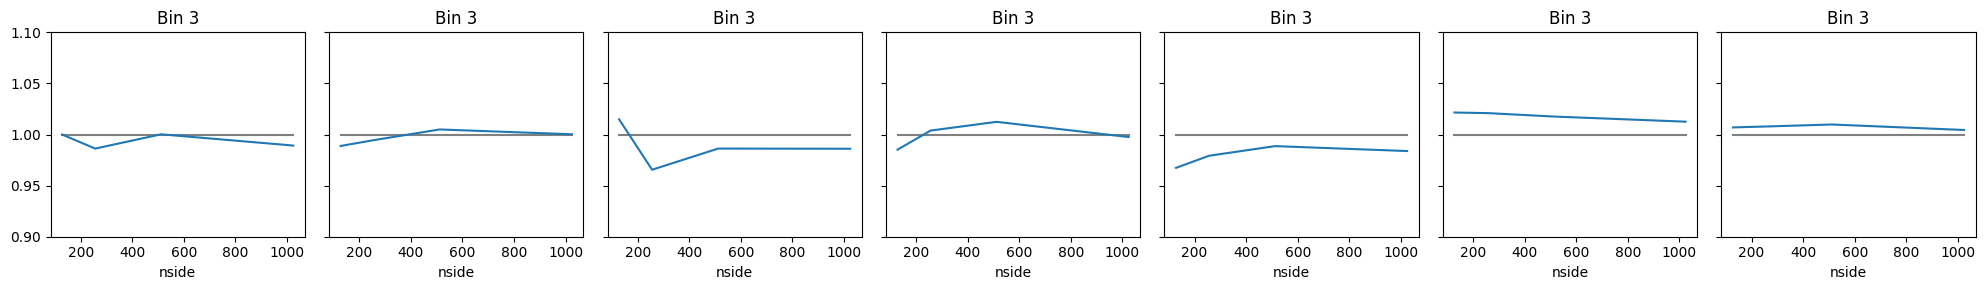

In [13]:
# Check dependence with scale
nns = [1024,512,256,128]
#E_coeff = dict()
#for tomo in maps_Gower:
#    E_coeff[tomo] = np.zeros(len(nns))
#for i,nside_out in enumerate(nns):
#    for tomo in maps_Gower:
#        A = (hp.ud_grade(maps_Gower[tomo]['EN'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
#        B = (hp.ud_grade(maps_Gower[tomo]['EN_nosc'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
#        E_coeff[tomo][i] =  (np.sqrt(np.mean(A)/np.mean(B)))

nns = [1024,512,256,128]
ee_coeff = dict()
for tomo in maps_Gower:
    ee_coeff[tomo] = np.zeros(len(nns))
for i,nside_out in enumerate(nns):
    for tomo in maps_Gower:
        
        A = (hp.ud_grade(maps_Gower[tomo]['e1n'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower[tomo]['e2n'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        B = (hp.ud_grade(maps_Gower[tomo]['e1r_map0_ref'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower[tomo]['e2r_map0_ref'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        ee_coeff[tomo][i] =  (np.sqrt(np.mean(A)/np.mean(B)))


fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)

for tomo in range(7):
    ax = axes[tomo]
    ax.plot(nns,np.ones(len(nns)),color = 'grey')
    ax.plot(nns,ee_coeff[tomo]**2)
    ax.set_title(f'Bin {i}' if i > 0 else 'Non-tomo')
    ax.set_xlabel("nside")
    ax.set_ylim([0.9,1.1])
plt.tight_layout()
plt.show()


# Compute kappa maps

In [8]:
# simulated --------------------
for tomo in maps_Gower.keys():
    mask = maps_Gower[tomo]['e1']!=0
    K_noisefree,KB_noisefree,_,_ = g2k_sphere(maps_Gower[tomo]['g1_map'], maps_Gower[tomo]['g2_map'],mask, nside=nside_maps, lmax=3*nside_maps-1)
    K,KB,_,_ = g2k_sphere(maps_Gower[tomo]['e1'], maps_Gower[tomo]['e2'],mask, nside=nside_maps, lmax=3*nside_maps-1)
    KN,KBN,_,_ = g2k_sphere(maps_Gower[tomo]['e1n'], maps_Gower[tomo]['e2n'], mask, nside=nside_maps, lmax=3*nside_maps-1)
    KN_nosc,KBN_nosc,_,_ = g2k_sphere(maps_Gower[tomo]['e1r_map0_ref'], maps_Gower[tomo]['e2r_map0_ref'],mask, nside=nside_maps, lmax=3*nside_maps-1)

    maps_Gower[tomo]['E_noisefree'] = K_noisefree*mask
    maps_Gower[tomo]['B_noisefree'] = KB_noisefree*mask
    maps_Gower[tomo]['E'] = K*mask
    maps_Gower[tomo]['B'] = KB*mask
    maps_Gower[tomo]['EN'] = KN*mask
    maps_Gower[tomo]['BN'] = KBN*mask
    maps_Gower[tomo]['EN_nosc'] = KN_nosc*mask
    maps_Gower[tomo]['BN_nosc'] = KBN_nosc*mask


/global/u2/m/mgatti/LSS_forward_model/LSS_forward_model/PKDGRAV_and_postprocessing_utilities.py:926: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/global/u2/m/mgatti/LSS_forward_model/LSS_forward_model/PKDGRAV_and_postprocessing_utilities.py:926: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/global/u2/m/mgatti/LSS_forward_model/LSS_forward_model/PKDGRAV_and_postprocessing_utilities.py:927: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/global/u2/m/mgatti/LSS_forward_model/LSS_forward_model/PKDGRAV_and_postprocessing_utilities.py:927: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5


In [147]:


maps_data = dict()
for tomo in maps_Gower.keys():
    maps_data[tomo] = dict()

    pix = convert_to_pix_coord(cats_Euclid[tomo]['ra'],cats_Euclid[tomo]['dec'], nside=nside_maps)
    


    n_map = np.zeros(hp.nside2npix(nside_maps))
    
                    
    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w'])
    e1_map = np.zeros(hp.nside2npix(nside_maps))
    e2_map = np.zeros(hp.nside2npix(nside_maps))

    unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


    e1_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['e1']*cats_Euclid[tomo]['w'])
    e2_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['e2']*cats_Euclid[tomo]['w'])


    mask_sims = n_map != 0.
    e1_map[mask_sims] =  e1_map[mask_sims]/(n_map[mask_sims])
    e2_map[mask_sims] =  e2_map[mask_sims]/(n_map[mask_sims])

    K,KB,_,_ = g2k_sphere(e1_map,e2_map,mask_sims, nside=nside_maps, lmax=3*nside_maps-1)
    
    maps_data[tomo] = {'e1':e1_map,
                       'e2':e2_map,
                       'E':K*mask_sims,
                       'B':KB*mask_sims}

In [9]:
#np.save('/pscratch/sd/m/mgatti/euclid/maps_data.npy',maps_data)
np.save('/pscratch/sd/m/mgatti/euclid/maps_Gower.npy',maps_Gower)

# Plot power spectra

In [308]:
# Initialize dictionaries
cl_gower_dict = {}
cl_gower_noise_dict = {}
cl_data_dict = {}
cl_data_noise_dict = {}

Bcl_gower_dict = {}
Bcl_gower_noise_dict = {}
Bcl_data_dict = {}
Bcl_data_noise_dict = {}

# Loop through tomographic bins
for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        if i >= j:
            cl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['E'], maps_Gower[j]['E'])
            cl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN'], maps_Gower[j]['EN'])
            cl_data_dict[(i, j)] = hp.anafast(maps_data[i]['E'], maps_data[j]['E'])
            cl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN_nosc'], maps_Gower[j]['EN_nosc'])

            
            Bcl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['B'], maps_Gower[j]['B'])
            Bcl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN'], maps_Gower[j]['BN'])
            Bcl_data_dict[(i, j)] = hp.anafast(maps_data[i]['B'], maps_data[j]['B'])
            Bcl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN_nosc'], maps_Gower[j]['BN_nosc'])



In [153]:
# Initialize dictionaries


cl_gower_nf_dict = {}
cl_gower_dict = {}
cl_gower_noise_dict = {}
cl_data_dict = {}
cl_data_noise_dict = {}

Bcl_gower_dict = {}
Bcl_gower_noise_dict = {}
Bcl_data_dict = {}
Bcl_data_noise_dict = {}

# Loop through tomographic bins
for i in range(7):
    for j in range(7):
        if i >= j:
            cl_gower_nf_dict[(i, j)] = hp.anafast(maps_Gower[i]['E_noisefree'], maps_Gower[j]['E_noisefree'])
            cl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['E'], maps_Gower[j]['E'])
            cl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN'], maps_Gower[j]['EN'])
            cl_data_dict[(i, j)] = hp.anafast(maps_data[i]['E'], maps_data[j]['E'])
            cl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['EN_nosc'], maps_Gower[j]['EN_nosc'])

            
            Bcl_gower_dict[(i, j)] = hp.anafast(maps_Gower[i]['B'], maps_Gower[j]['B'])
            Bcl_gower_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN'], maps_Gower[j]['BN'])
            Bcl_data_dict[(i, j)] = hp.anafast(maps_data[i]['B'], maps_data[j]['B'])
            Bcl_data_noise_dict[(i, j)] = hp.anafast(maps_Gower[i]['BN_nosc'], maps_Gower[j]['BN_nosc'])



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from orphics import stats

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

from scipy.signal import savgol_filter



c_2 = rgb_to_hex((239, 96, 96))
c5 = rgb_to_hex((255, 194, 0)) 
c_4 = rgb_to_hex((121, 183, 179)) 
c_cs = "black"


binner = stats.bin1D(np.arange(20,3072,300))

fig, axes = plt.subplots(6, 8, figsize=(7, 5), sharex=True, sharey=True)

for i in range(1, 7):
    for j in range(1, 7):

        if i >= j:
            # E-modes → lower triangle: plot in axes[i-1, j-1]
            ax = axes[i - 1, j - 1]

            ell = np.arange(len(cl_gower_dict[(i, j)]))
            cents,g = binner.bin(ell,cl_gower_dict[(i, j)] - cl_gower_noise_dict[(i, j)])
            cents,d = binner.bin(ell,cl_data_dict[(i, j)] - cl_data_noise_dict[(i, j)])

            ax.axhline(0,color = 'grey')
            ax.plot(cents,g*cents, color=c_2)
            ax.plot(cents,d*cents, color=c_4)
            #ax.set_xscale('log')
            ax.set_xlim([40, 2000])
            ax.text(0.05, 0.95, f"{i},{j} E", transform=ax.transAxes, fontsize=8, va='top')

        if i <= j:
            # B-modes → upper triangle: plot in axes[i-1, j]  (shifted right by one)
            ax = axes[i - 1, j+1]
            cents,g = binner.bin(ell,Bcl_gower_dict[(j, i)] - Bcl_gower_noise_dict[(j, i)])
            cents,d = binner.bin(ell,Bcl_data_dict[(j, i)] - Bcl_data_noise_dict[(j, i)])

            ax.axhline(0,color = 'grey')
            ax.plot(cents,g*cents, color=c_2)
            ax.plot(cents,d*cents, color=c_4)
            #ax.set_xscale('log')
            ax.set_xlim([40, 2000])
            ax.text(0.05, 0.95, f"{i},{j} B", transform=ax.transAxes, fontsize=8, va='top')
            

        # Clean ticks
        ax = axes[i - 1, j - 1 if i >= j else j]
        #if i < 5:
        #   ax.set_xticklabels([])
        if (j < 6 and i >= j) or (j < 5 and i < j):  # keep leftmost ylabels only
            ax.set_yticklabels([])
            
# Add global labels
fig.text(0.5, -0.02, r'Multipole $\ell$', ha='center')
fig.text(-0.02, 0.5, r'($C_\ell^{\rm E/B} - N_\ell)\ell$ ', va='center', rotation='vertical')

# Legend once
axes[0, 0].plot([], [], color='tab:blue', label='Gower st.')
axes[0, 0].plot([], [], color='tab:orange', label='Data')
axes[0, 0].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [267]:
0

0

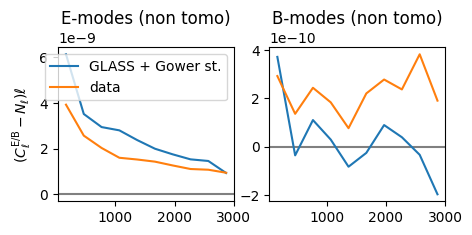

In [155]:

fig, axes = plt.subplots(1, 2, figsize=(5, 2))  # 1 row, 2 columns

i = 0
j = 0
cents,g = binner.bin(ell,cl_gower_dict[(i, j)] - cl_gower_noise_dict[(i, j)])
cents,d = binner.bin(ell,cl_data_dict[(i, j)] - cl_data_noise_dict[(i, j)])
axes[0].axhline(0,color = 'grey')
axes[1].axhline(0,color = 'grey')
axes[0].plot(cents,g*cents, label='GLASS + Gower st.')
axes[0].plot(cents,d*cents,  label='data')
axes[0].set_title('E-modes (non tomo)')
axes[0].legend()

i = 0
j = 0
cents,g = binner.bin(ell,Bcl_gower_dict[(j, i)] - Bcl_gower_noise_dict[(j, i)])
cents,d = binner.bin(ell,Bcl_data_dict[(j, i)] - Bcl_data_noise_dict[(j, i)])

axes[1].plot(cents,g*cents, label='GLASS + Gower st.')
axes[1].plot(cents,d*cents,  label='data')
axes[1].set_title('B-modes (non tomo)')
#axes[1].legend()
axes[0].set_ylabel(r'($C_\ell^{\rm E/B} - N_\ell)\ell$')
#plt.tight_layout()
plt.show()

# Plot second & third moments

In [208]:
# Initialize dictionaries
mom_gower_dict = {}
mom_gower_noise_dict = {}
mom_gower_noise_nosc_dict = {}
mom_data_dict = {}

scales = [3,6,12,24,48,96]

sm_maps_E_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_E_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_EN_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['EN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_EN_nosc_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['EN_nosc'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])



In [ ]:

sm_maps_B_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_B_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_BN_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['BN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])
sm_maps_BN_nosc_sims = np.array([np.array([(hp.smoothing(maps_Gower[tomo]['BN_nosc'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower.keys()])


In [209]:
mom_gower_dict[2]  = dict()
mom_gower_dict[3]  = dict()

mom_data_dict[2]  = dict()
mom_data_dict[3]  = dict()


# Loop through tomographic bins
for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        if i >= j:

            mom_gower_dict[2][(i,j)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j],axis=1) - np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j],axis=1)
            mom_data_dict[2][(i,j)] =np.mean(sm_maps_E_data[i]*sm_maps_E_data[j],axis=1) - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j],axis=1) 


for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        for k in range(nz.shape[0]):
            mom_gower_dict[3][(i,j,k)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j]*sm_maps_E_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_data_dict[3][(i,j,k)]  = np.mean(sm_maps_E_data[i]*sm_maps_E_data[j]*sm_maps_E_data[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 


mom_data_noise_sc = dict()
mom_gower_noise_sc = dict()
mom_data_noise_sc [3]  = dict()
mom_gower_noise_sc[3]  = dict()
for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        for k in range(nz.shape[0]):
            mom_data_noise_sc[3][(i,j,k)] = np.mean(sm_maps_E_data[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_gower_noise_sc[3][(i,j,k)]  = np.mean(sm_maps_E_sims[i]*sm_maps_EN_sims[j]*sm_maps_EN_sims[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 



mom_data_noise = dict()
mom_gower_noise= dict()
mom_data_noise[3]  = dict()
mom_gower_noise[3]  = dict()
for i in range(nz.shape[0]):
    for j in range(nz.shape[0]):
        for k in range(nz.shape[0]):
            mom_data_noise[3][(i,j,k)] = np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]*sm_maps_EN_nosc_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_gower_noise[3][(i,j,k)]  = np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]*sm_maps_EN_sims[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 


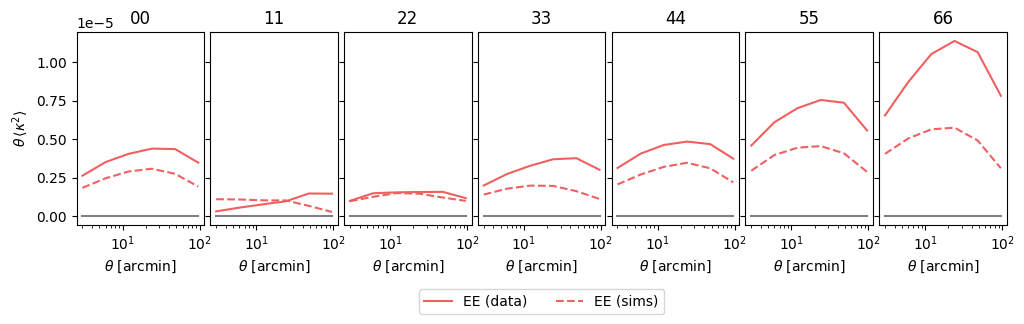

In [288]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 6
for i in range(7):
    ax = axes[i]
    ax.plot(np.array(scales), 0*mom_gower_dict[2][(i, i)] * np.array(scales), color = 'grey')
    ax.plot(np.array(scales), mom_gower_dict[2][(i, i)] * np.array(scales), label='EE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_dict[2][(i, i)] * np.array(scales), label='EE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{i}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if i == 0:
        ax.set_ylabel(r'$\theta \, \langle \kappa^2\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


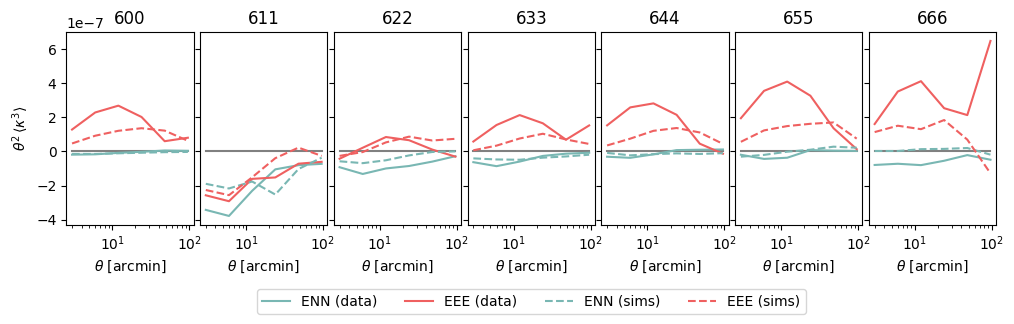

In [287]:



fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 6
for j in range(7):
    ax = axes[j]
    ax.plot(np.array(scales), 0*mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), -mom_gower_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (data)',color = c_4)
    ax.plot(np.array(scales),- mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


# WPH

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pywph as pw
import healpy as hp

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2 = rgb_to_hex((239, 96, 96))
c5 = rgb_to_hex((255, 194, 0)) 
c_4 = rgb_to_hex((121, 183, 179)) 
c_cs = "black"



def project_map(map_):
    ra_ = 60
    dec_ = -45
    nside_maps = 1024
    xsize = 1024
    res = hp.nside2resol(nside_maps, arcmin=True)
    projected = hp.gnomview((map_), rot=(ra_,dec_), xsize=xsize ,no_plot=True,reso=res,return_projected_map=True)
    return projected
    
maps_data = np.load('/pscratch/sd/m/mgatti/euclid/maps_data.npy',allow_pickle=True).item()
maps_Gower = np.load('/pscratch/sd/m/mgatti/euclid/maps_Gower.npy',allow_pickle=True).item()


/global/common/software/des/mgatti/py38_clone/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
projected_data = dict()
projected_Gower = dict()
projected_data['E'] = dict()
projected_data['EN'] = dict()

projected_Gower['E'] = dict()
projected_Gower['EN'] = dict()
for tomo in maps_data.keys():
    projected_data['E'][tomo] = project_map(maps_data[tomo]['E'])
    projected_data['EN'][tomo] = project_map(maps_Gower[tomo]['EN_nosc'])

    projected_Gower['E'][tomo] = project_map(maps_Gower[tomo]['E'])
    projected_Gower['EN'][tomo] = project_map(maps_Gower[tomo]['EN'])
     

In [34]:
WPH_data = dict()
WPH_data['EE'] = dict()
WPH_data['EN'] = dict()
WPH_data['NE'] = dict()
WPH_Gower = dict()
WPH_Gower['EE'] = dict()
WPH_Gower['EN'] = dict()
WPH_Gower['NE'] = dict()
M = 1024
N = 1024
J = 7
j_min = 0
L = 3
dn = 0 

def compute_wph(M,N,J,L,j_min,dn,patch1,patch2):
    wph_op = pw.WPHOp(M, N, J, L=L,j_min=j_min, dn=dn, device='cpu')
    wph = wph_op([patch1, patch2], cross=True, ret_wph_obj=True)
    wph.to_isopar()
    s00, s00_indices = wph.get_coeffs("S00")
    s11, s11_indices = wph.get_coeffs("S11")
    s01, s01_indices = wph.get_coeffs("S01")
    c01, c01_indices = wph.get_coeffs("C01")

    s00_indices =    np.array(['S00_'+'j'+str(s00_indices[ii][0])+'j'+str(s00_indices[ii][3]) for ii in range(len(s00_indices))])
    s11_indices =    np.array(['S11_'+'j'+str(s11_indices[ii][0])+'j'+str(s11_indices[ii][3]) for ii in range(len(s11_indices))])
    s01_indices =    np.array(['S01_'+'j'+str(s01_indices[ii][0])+'j'+str(s01_indices[ii][3]) for ii in range(len(s01_indices))])
    c01_indices =    np.array(['C01_'+'j'+str(c01_indices[ii][0])+'j'+str(c01_indices[ii][3])+'dl'+str(c01_indices[ii][4]) for ii in range(len(c01_indices))])

    results = {
        's00': s00,
        's11': s11,
        's01': s01,
        'c01': c01,
        's00_indices': s00_indices,
        's11_indices': s11_indices,
        's01_indices': s01_indices,
        'c01_indices': c01_indices,
    }
    return results


for tomo1 in projected_data['E'].keys():
    for tomo2 in projected_data['E'].keys():
        print (tomo1,tomo2)
        results = compute_wph(M,N,J,L,j_min,dn,projected_data['E'][tomo1],projected_data['E'][tomo2])
        WPH_data['EE'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_data['E'][tomo1],projected_data['EN'][tomo2])
        WPH_data['EN'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_data['EN'][tomo1],projected_data['E'][tomo2])
        WPH_data['NE'][(tomo1,tomo2)] = results


        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['E'][tomo1],projected_Gower['E'][tomo2])
        WPH_Gower['EE'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['E'][tomo1],projected_Gower['EN'][tomo2])
        WPH_Gower['EN'][(tomo1,tomo2)] = results

        results = compute_wph(M,N,J,L,j_min,dn,projected_Gower['EN'][tomo1],projected_Gower['E'][tomo2])
        WPH_Gower['NE'][(tomo1,tomo2)] = results

0 0
0 1
0 2
0 3
0 4
1 1
1 2
1 3
1 4
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 2
5 3
5 4
5 5
5 6
6 1
6 2
6 3
6 4
6 5
6 6


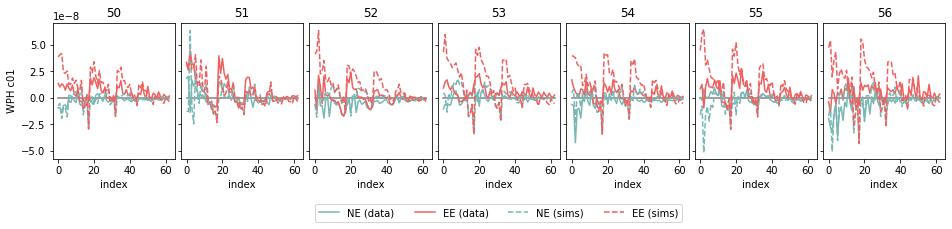

In [51]:



fig, axes = plt.subplots(1, 7, figsize=(16, 2.5), sharex=True, sharey=True)

i = 5
for j in range(7):
    ax = axes[j]
    ax.plot( 0*WPH_data['EN'][(i,j)]['c01'], color = 'grey')
    ax.plot(WPH_data['NE'][(i,j)]['c01'], label='NE (data)',color = c_4)
    ax.plot(WPH_data['EE'][(i,j)]['c01'], label='EE (data)',color = c_2)
    ax.plot(WPH_Gower['NE'][(i,j)]['c01'], label='NE (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(WPH_Gower['EE'][(i,j)]['c01'], label='EE (sims)',color = c_2, linestyle = 'dashed')

    ax.set_title(f'{i}{j}')
    ax.set_xlabel('index')
    if j == 0:
        ax.set_ylabel(r'WPH c01')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


0

In [45]:
WPH_data['NE'][(i,j)]['c01_indices']

array(['C01_j0j1dl0', 'C01_j0j1dl1', 'C01_j0j1dl2', 'C01_j0j2dl0',
       'C01_j0j2dl1', 'C01_j0j2dl2', 'C01_j0j3dl0', 'C01_j0j3dl1',
       'C01_j0j3dl2', 'C01_j0j4dl0', 'C01_j0j4dl1', 'C01_j0j4dl2',
       'C01_j0j5dl0', 'C01_j0j5dl1', 'C01_j0j5dl2', 'C01_j0j6dl0',
       'C01_j0j6dl1', 'C01_j0j6dl2', 'C01_j1j2dl0', 'C01_j1j2dl1',
       'C01_j1j2dl2', 'C01_j1j3dl0', 'C01_j1j3dl1', 'C01_j1j3dl2',
       'C01_j1j4dl0', 'C01_j1j4dl1', 'C01_j1j4dl2', 'C01_j1j5dl0',
       'C01_j1j5dl1', 'C01_j1j5dl2', 'C01_j1j6dl0', 'C01_j1j6dl1',
       'C01_j1j6dl2', 'C01_j2j3dl0', 'C01_j2j3dl1', 'C01_j2j3dl2',
       'C01_j2j4dl0', 'C01_j2j4dl1', 'C01_j2j4dl2', 'C01_j2j5dl0',
       'C01_j2j5dl1', 'C01_j2j5dl2', 'C01_j2j6dl0', 'C01_j2j6dl1',
       'C01_j2j6dl2', 'C01_j3j4dl0', 'C01_j3j4dl1', 'C01_j3j4dl2',
       'C01_j3j5dl0', 'C01_j3j5dl1', 'C01_j3j5dl2', 'C01_j3j6dl0',
       'C01_j3j6dl1', 'C01_j3j6dl2', 'C01_j4j5dl0', 'C01_j4j5dl1',
       'C01_j4j5dl2', 'C01_j4j6dl0', 'C01_j4j6dl1', 'C01_j4j6d